In [1]:
import igraph as ig
import math
import pandas as pd
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange, date2num
import random
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        }
params = {'legend.fontsize': 16,
          'legend.handlelength': 2.}
plt.rcParams.update(params)

import seaborn as sns
import itertools
import csv
import matplotlib.ticker as mticker

class Labeloffset():
    def __init__(self,  ax, label="", axis="y"):
        self.axis = {"y":ax.yaxis, "x":ax.xaxis}[axis]
        self.label=label
        ax.callbacks.connect(axis+'lim_changed', self.update)
        ax.figure.canvas.draw()
        self.update(None)

    def update(self, lim):
        fmt = self.axis.get_major_formatter()
        self.axis.offsetText.set_visible(False)
        self.axis.set_label_text(self.label + " "+ fmt.get_offset() )

In [2]:
df = pd.read_excel ('Data_Italy.xlsx')  # data

In [3]:
# double logistic function to calculate beta(t)
def double_smoothlog(time, bound1 , bound2, rate1 , rate2 , midpoint1 , midpoint2):
    result = []
    mini = 0
    maxi = time
    for x in range(time):
        if (midpoint1 > maxi | midpoint2 > maxi | midpoint1 < mini | midpoint2 < mini | midpoint1 > midpoint2):
            stop('midpoints not in range!')
        t1 = 1 / (1 + math.exp(-rate1*(x - midpoint1)))
        t2 = 1 / (1 + math.exp( rate2*(x - midpoint2)))
        out = bound1 + (bound2-bound1) * ((t1 + t2) - 1)
        result.append(out)
    return(result)


In [4]:
def secfxn(newg,bett,efficacy):
    beta = bett
    inf_nodes = []
    first_con = []
    sec_contacts = []
    sec_con = []
    vac_eff = efficacy
    snbs = []
    for inf in newg.vs.select(state_eq = "E"):
        newg.vs[inf.index]["duration"] += 1 
        if newg.vs[inf.index]["duration"] in range(5,19):  #(7,21)
            newg.vs[inf.index]["state"] = "I"
        for na in newg.neighbors(inf): #iterates through neighbours of that node
            if newg.vs[na]["state"] == "E":    #previously exposed neighbours
                newg.vs[na]["somecol"] = "tfirst"
            if newg.vs[na]["state"] == "S": #if node is infected...
                s=np.random.binomial(1, beta,1)
                if s == 1:
                    newg.vs[na]["state"] = 'E'  # first contacts exposed
                    inf_nodes.append(na)
            if (na not in inf_nodes):
                newg.vs[na]["somecol"] = 'first'
        
            
    for ele in newg.vs.select(somecol_eq = 'first'):
        newg.vs[ele.index]["tcount"] += 1
        for elenb in newg.neighbors(ele):         # select neighbour/contact of contact to vaccinate  
            newg.vs[elenb]["somecol"] = 'second'
    for tse in newg.vs.select(somecol_eq = 'second'):
        if newg.vs[tse.index]["state"] == "S":
            newg.vs[tse.index]["somecol_eq"] = "number2"
            sec_contacts.append(tse)
                
        
    for sec in newg.vs.select(somecol_eq = 'number2'):
        newg.vs[sec.index]["tcount"] += 1
        
    for thefirst in newg.vs.select(somecol_eq = 'first'):
        if newg.vs[thefirst.index]["tcount"]== 4:
            B = np.random.binomial(1, (1-vac_eff)*beta,1)  #vaccinate first contacts after 3 days
            if B == 0:
                newg.vs[thefirst.index]["state"] = "V"

    for scon in sec_contacts:
        if newg.vs[scon.index]["tcount"]== 4:
            C = np.random.binomial(1, (1-vac_eff)*beta,1)  # vaccinate contact of contact after 3 days
            if C == 0:
                newg.vs[scon.index]["state"] = "V"

    for mn in newg.vs.select(state_eq = "I"): #iterates through each node in the network
        newg.vs[mn.index]["duration"] += 1 #from day 0 to infect_len this node continues to infect                                
        for nbm in newg.neighbors(mn): #iterates through neighbours of that node
            if newg.vs[nbm]["state"] == "S": #if node is infected...
                j=np.random.binomial(1, beta,1)
                if j == 1:
                    newg.vs[nbm]["state"] = "E"
        if newg.vs[mn.index]["duration"] in range(19,Time):
            newg.vs[mn.index]["state"] = 'R'
 
    return(len(newg.vs.select(state_eq = "S")),len(newg.vs.select(state_eq = "E")),len(newg.vs.select(state_eq = "I")),len(newg.vs.select(state_eq = "R")),len(newg.vs.select(state_eq = "V")))

In [5]:
def simfxn(Time,popul):
    vac_eff = 0.4 # vaccine efficacy
    expolim = 0.0100000
    bound1 = 0.028
    bound2 = 0.001
    rate1 = 0.09
    rate2 = 0.04
    midpoint1 = 50
    midpoint2 = 126
    beta = double_smoothlog(Time, bound1 , bound2, rate1 , rate2 , midpoint1 , midpoint2)
    color_dict = {"S": "blue", "I": "red", "R": "green", "V":"orange"}
    g = ig.Graph.Erdos_Renyi(popul, m=5*popul)
    pop = g.vcount()
    g.vs["state"] = "S"
    g.vs["duration"] = 0
    g.vs["somecol"] = 'THB'
    g.vs["number"] = 'random'

    #randomly select an infected node to start epidemic
    i = rd.randint(0, pop-1)
    g.vs[i]["state"] = "E"  
    nb_S = [pop]
    nb_E = [1]
    nb_I = [0]
    nb_R = [0]
    nb_V = [0]
    exposed_vac = []
    Time = Time 
    count = 0   # count the number of exposed
    inf_nodes = []
    infec_nodes = []
    sec_contacts = []
    g.vs["tcount"] = 0 
    newtime = 0
    new_exposed =[]
    allstates = []
    allduration = []
    thestates = []
    saveg = []
    
    for time in range(Time): #no. of days 
        saveg.append(g)        
        newbet = beta[time]
        if len(infec_nodes) != 0:
            newtime = infec_nodes[0][0]    # time at which exposed perc is reached
            newg = saveg[newtime]
            secfxn(newg,newbet,vac_eff)
        else:
            for n in g.vs.select(state_eq = "E"): #iterates through each node in the network
                g.vs[n.index]["duration"] += 1 
                if count == round(expolim*popul):
                    break
                else:
                    for nb in g.neighbors(n): #iterates through neighbours of that node
                        if g.vs[nb]["state"] == "S": #if node is infected...
                            s=np.random.binomial(1, beta[time],1)
                            if s == 1:
                                g.vs[nb]["state"] = "E" 
                                count = len(g.vs.select(state_eq = "E"))
                                if count == round(expolim*popul):
                                    infec_nodes.append([time,count])
                                    break
                                else:
                                    continue
                                break
                            else:
                                continue
                            break
                        else:
                            continue
                        break
                if g.vs[n.index]["duration"] in range(5,19):  #(7,21)
                    g.vs[n.index]["state"] = 'I'
            for m in g.vs.select(state_eq = "I"): #iterates through each node in the network
                g.vs[m.index]["duration"] += 1 #from day 0 to infect_len this node continues to infect                                
                if count == round(expolim*popul):
                    break
                else:
                    for nbm in g.neighbors(m): #iterates through neighbours of that node
                        if g.vs[nbm]["state"] == "S": #if node is infected...
                            j=np.random.binomial(1, beta[time],1)
                            if j == 1:
                                g.vs[nbm]["state"] = "E"
                                count = len(g.vs.select(state_eq = "E"))
                                if count == round(expolim*popul):
                                    infec_nodes.append([time,count])
                                    break
                                else:
                                    continue
                                break
                            else:
                                continue
                            break
                        else:
                            continue
                        break
                if g.vs[m.index]["duration"] in range(19,Time):
                    g.vs[m.index]["state"] = 'R'

        nb_S.append(len(g.vs.select(state_eq = "S"))) #no. of susceptibles in population
        nb_E.append(len(g.vs.select(state_eq = "E"))) #no. of recovereds in population
        nb_I.append(len(g.vs.select(state_eq = "I"))) #no. of infecteds in population
        nb_R.append(len(g.vs.select(state_eq = "R"))) #no. of recovereds in population
        nb_V.append(len(g.vs.select(state_eq = "V"))) #no. of recovereds in population       

    return(nb_S,nb_E,nb_I,nb_R,nb_V,infec_nodes)

In [6]:
#
Time = 359  # time
popul = 1000  # total population
rep = 50  # number of times to repeat simulation
#repeat simulation 'rep' number of times and store outcome
simout=simfxn(Time,popul)
datavector = []
for i in range(rep):          
    simu = simfxn(Time,popul)
    datavector.append(simu)

In [7]:
# plot results from simulations
# plt.figure(figsize=(10.5, 5))

# plt.plot([x/popul for x in simout[0]], label='S',color = '#1f77b4')
# plt.plot([x/popul for x in simout[1]], label='E',color = 'yellow')
# plt.plot([x/popul for x in simout[2]], label='I',color = '#d62728')
# plt.plot([x/popul for x in simout[3]], label='R',color = '#2ca02c')
# plt.plot([x/popul for x in simout[4]], label='V',color = '#ff7f0e')
# plt.legend(loc='right')

i_each = []

for n in datavector:
    sList = [x / popul for x in n[0]]
    eList = [x / popul for x in n[1]]
    iList = [x / popul for x in n[2]]
    rList = [x / popul for x in n[3]]
    vList = [x / popul for x in n[4]]
     
#     plt.plot(sList,color = '#1f77b4')
#     plt.plot(eList,color = 'yellow')
#     plt.plot(iList,color = '#d62728')
#     plt.plot(rList,color = '#2ca02c')
#     plt.plot(vList,color = '#ff7f0e')
       
    i_each.append(iList)

    
# plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
# plt.ylabel('Population', fontsize=30) 
# plt.xlabel('Time(days)', fontsize=30)
# plt.show()

# plt.savefig('SEIRV_plot.pdf', bbox_inches='tight')



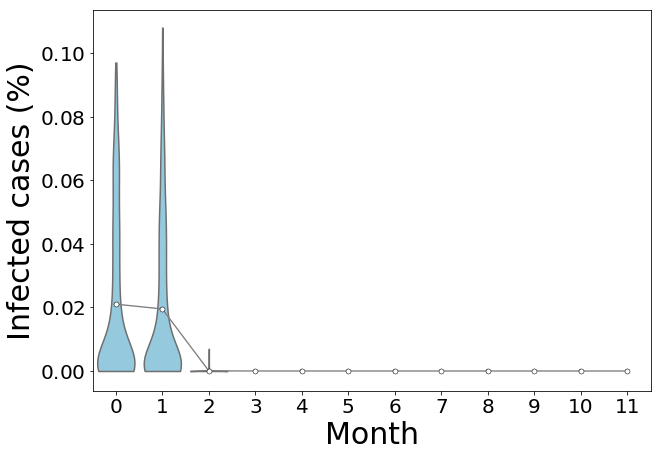

In [8]:
# VIOLIN PLOTS
#extract infection values and put in a dataframe
flat_list = [item for sublist in i_each for item in sublist]  
flat_list = []
for sublist in i_each:
    for item in sublist:
        flat_list.append(item)
        
datafr = pd.DataFrame(flat_list)

# group data into months
lst = range(0,12)
itl = list(itertools.chain.from_iterable(itertools.repeat(x, 30) for x in lst))
datafr = datafr.assign(month=itl*rep) 
datafr.columns=["inf","months"]
datafr['inf'] = pd.to_numeric(datafr['inf'], errors='coerce') # convert to numeric

#find the mean value for each month
mean = datafr.groupby(['months'])['inf'].mean().reset_index()
mean_col = datafr.groupby(['months'])['inf'].mean() # d
datafr = datafr.set_index(['months']) # 
datafr['mean_col'] = mean_col
datafr = datafr.reset_index() 
 
# plot violins
plt.figure(figsize=(10, 7))
qq = sns.violinplot(x="months", y="inf", color="skyblue",data=datafr,scale='count', bw=0.25,cut=0, inner=None)
# sns.stripplot(x="months", y="inf", data=datafr, jitter=True)
sns.swarmplot(x="months", y="inf", data=mean, color='white',edgecolor="black",linewidth=0.5, size=5)
sns.pointplot(x="months", y="inf", data=mean, color='grey',scale=0.5)
qq.set_ylabel("Infected cases (%)",fontsize=30)
qq.set_xlabel("Month",fontsize=30)
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2,2))
qq.yaxis.set_major_formatter(formatter)
qq.yaxis.offsetText.set_fontsize(18)
plt.setp(qq.collections, alpha=1.0)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)

plt.show()

#plt.savefig('violin_plot.pdf', bbox_inches='tight')
